# Loading Data

In [8]:
# Load libraries
library('tm')
library('dplyr')
library('stringr')
library('tidyr')
library('factoextra')
library('ggplot2')

In [6]:
# Load Data
raw <- read.csv('data/airplane_crashes_since_1900s.csv', 
                stringsAsFactors = FALSE)

In [7]:
# Some initial formatting and cleaning
crashes <-
    raw %>%
    mutate(Date = as.Date(Date, format = "%m/%d/%Y")) %>%
    rename(Flight = `Flight..`)

# Load text as corpus
rawtxt <- VCorpus(VectorSource(crashes$Summary))

# Cleaning
rawtxt <- tm_map(rawtxt, removePunctuation)
rawtxt <- tm_map(rawtxt, content_transformer(tolower))
rawtxt <- tm_map(rawtxt, removeWords, stopwords("english"))
rawtxt <- tm_map(rawtxt, stripWhitespace)

# Create document-terms matrix, removing generic terms
dtm <- DocumentTermMatrix(rawtxt, control = list(stopwords = c("aircraft", "plane", "crashed", "crash", "flight", "flew", "killed", "due", "resulted", "cause", "caused", "one", "two")))
dtm

# Remove sparse terms from DTM
dtms <- removeSparseTerms(dtm, 0.97)

<<DocumentTermMatrix (documents: 5268, terms: 9863)>>
Non-/sparse entries: 75188/51883096
Sparsity           : 100%
Maximal term length: 32
Weighting          : term frequency (tf)

# 1) Clustering Words

In [9]:
# Compute distance matrix
d <- dist(t(dtms), method = "euclidian")

# Compute K-means
km <- kmeans(d, 16, iter.max = 50, nstart = 10)

In [10]:
# Display results as a list
grouplist = function(input) {
    output <- list()
    for (i in 1:max(input)) {
        output[[i]] <- names(input[input == i]) 
    }
    for (i in output) {
        cat('* ')
        cat(i, sep = ", ")
        cat("\n")
    }
}

grouplist(km$cluster)

* engine
* continued, error, flames, heavy, hit, improper, maintain, minutes, rain, sea, stalled, turn, vfr, visibility
* accident, miles, pilots, route, terrain
* crew, landing
* takeoff
* airport, fire
* approach, runway
* cargo, ground, left, right, struck, taking
* pilot
* altitude, mountain
* attempting, land
* control, fuel
* air, emergency, failed, feet, loss, lost, power, shortly, wing
* conditions, weather
* area, descent, flying, fog, high, low, poor, short, trees
* failure


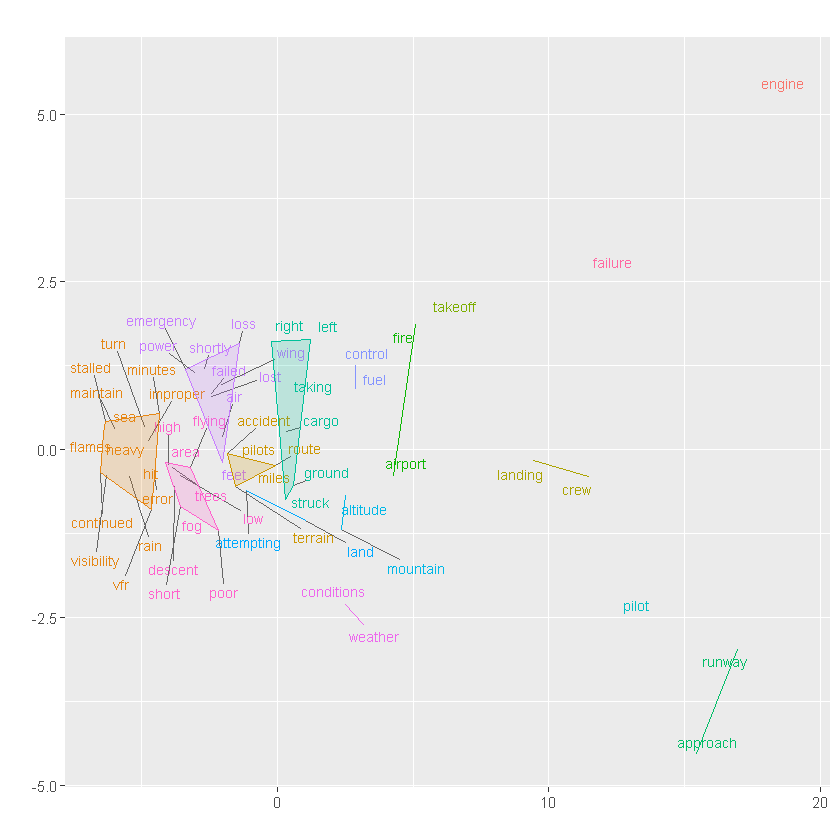

In [11]:
fviz_cluster(km, data = d, geom = "text", show.clust.cent = FALSE, repel = TRUE, labelsize = 3) +
    theme(legend.position = "none") +
    labs(title = "", x = "", y = "")

## Conclusion:
This tells us the different set of groups.
- Approaching the runway
- Altitude and hitting a mountain?
- Fuel fire at the airport
- Pilot (by his own fault)
- Engine and failure are probably together.
- ETC.

We can also see this in the table below. The correlation between words due to crashes

In [14]:
# Correlation Table
assocs <- findAssocs(dtm, as.character(freq[1:20, 1]), corlimit = 0.17)
assocs

$pilot
error  turn 
 0.18  0.18 

$approach
     final        ils instrument    descent      short     missed     visual 
      0.34       0.30       0.28       0.23       0.23       0.22       0.21 
 procedure    minimum    monitor stabilized procedures 
      0.19       0.18       0.18       0.18       0.17 

$engine
    power     right      shut      left emergency      loss    failed feathered 
     0.26      0.26      0.26      0.25      0.23      0.22      0.20      0.20 
propeller   engines   trouble 
     0.19      0.18      0.18 

$runway
       short          end      overran      taxiway      require    threshold 
        0.41         0.33         0.30         0.30         0.25         0.25 
         05r    180degree          aug  contentious          dim     entrance 
        0.23         0.23         0.23         0.23         0.23         0.23 
         nov         sane          sep      tarmaat        xiang       lights 
        0.23         0.23         0.23         0.23         0.23         0.22 
      length          137         5191       affect        befoe       cleard 
        0.21         0.20         0.20         0.20         0.20         0.20 
      closed    crossings      guayana        horse     negative nonpertinent 
        0.20         0.20         0.20         0.20         0.20         0.20 
  specifiair        fence         past         take       beyond        notam 
        0.20         0.19         0.19         0.19         0.18         0.18 
   perimeter         stop      touched         feet         slid 
        0.18         0.18         0.18         0.17         0.17 

$failure
contributing     maintain       pilots     accident   procedures     airplane 
        0.29         0.28         0.24         0.22         0.21         0.20 
      system     adequate  maintenance      provide   structural   adequately 
        0.20         0.19         0.19         0.19         0.19         0.18 
    properly          use    airplanes      monitor 
        0.18         0.18         0.17         0.17 

$crew
            atc         realize             853     reactionary             eal 
           0.27            0.24            0.23            0.23            0.21 
      situation             420             707   compensations        dragging 
           0.21            0.20            0.20            0.20            0.20 
hydrauliproblem         mirabel       montreals            ovht           peril 
           0.20            0.20            0.20            0.20            0.20 
   peterborough          repeat           seals        speaking        squarely 
           0.20            0.20            0.20            0.20            0.20 
     wingengine         yorkthe   constellation    coordination       different 
           0.20            0.20            0.19            0.19            0.19 
        upslope         declare         evasive        extended     overheating 
           0.19            0.18            0.18            0.18            0.18 
        advised          member         warning 
           0.17            0.17            0.17 

$landing
     gear emergency   attempt      make    forced attempted 
     0.46      0.32      0.26      0.25      0.19      0.17 

$airport
international         miles        return 
         0.29          0.22          0.22 

$weather
      adverse          poor           vfr     continued deteriorating 
         0.53          0.42          0.33          0.25          0.24 
          bad 
         0.20 

$altitude
  minimum      gain clearance      feet  maintain       low   descent      safe 
     0.33      0.25      0.23      0.22      0.21      0.20      0.19      0.19 

$takeoff
    aborted       abort     overran        code       comet    computed 
       0.23        0.18        0.18        0.17        0.17        0.17 
     modify  nonrevenue  nonroutine      partly permissable      strict 
       0.17        0.17        0.17        0.

# 2) Most Frequent Terms

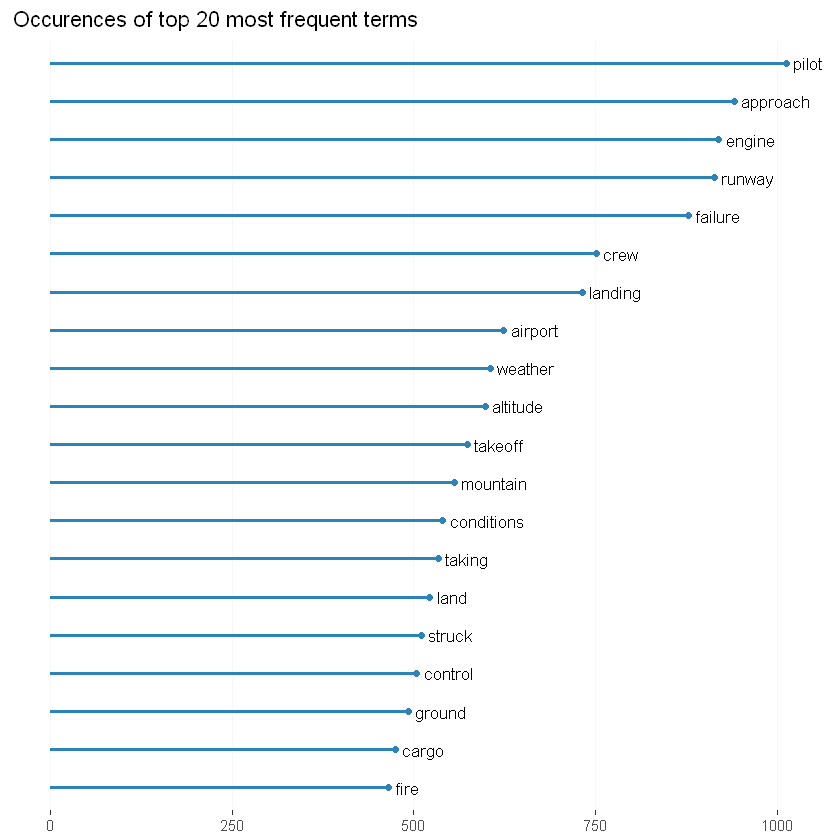

In [12]:
# Ordered terms by frequency
freq <- colSums(as.matrix(dtm))
freq <- 
    freq %>%
    data.frame(term = names(freq), frequency = freq) %>%
    select(term, frequency) %>%
    arrange(desc(frequency)) 

### Plot most frequent terms
ggplot(freq[1:20, ], aes(x = frequency, y = reorder(term, frequency))) + 
    geom_point(colour = "#2b83ba") + 
    geom_segment(aes(xend = 0, yend = term), size = 1, colour = "#2b83ba") +
    geom_text(aes(label = term, vjust = "middle", hjust = "left"), nudge_x = 10, size = 3.5) +
    theme(panel.background = element_rect(fill = "white"),
          panel.grid.major.x = element_line(colour = "#f7f7f7"),
          panel.grid.major.y = element_blank(),
          panel.grid.minor = element_blank(), 
          axis.text.y = element_blank(), 
          axis.title = element_blank(), 
          axis.ticks.y = element_blank()) +
    labs(title = "Occurences of top 20 most frequent terms")

## Conclusion:
I'm not surprised that **Pilot** is the most frequent word because it is usually on the pilot to get out of the situations that the plane is in. Not to mention he's flying the plane.

As for a hypothesis of the other words...

- **Engine** and **Failure**: As we saw above, they were seperate didn't seem to belong to any category. This is probably due to the fact that every crash is a failure. Also Engines are the main cause for why things don't work out. Maybe engine catches on fire. Engine was failing after being struck by lightning weather. 


- **Approach** and **Runway**: Luckily, it seems more times than not, the accidents happen on the runway. There could be other reasons for approach, for example approaching a mountain? Highly unlikely though. Usually happening at an **Airport** is more likely. That is why its one of the words.

The other ones seem self explanatory: too much cargo, landing/struck on the ground, and fire could be for a plethora of reasons